In [1]:
#pip install xgboost
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn import set_config #to display pipeline chart

set_config(display="diagram")  #https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_pipeline_display.html

## 1. Import Data

In [3]:
X_train = pd.read_csv('data_v1/train_all_feature.csv')

In [4]:
X_test= pd.read_csv('data_v1/test_all_feature.csv')

In [5]:
y_train = pd.read_csv('data_v1/y_train_new.csv')

In [6]:
y_test = pd.read_csv('data_v1/y_test_new.csv')

In [7]:
display(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(4328, 105)

(1082, 105)

(4328, 1)

(1082, 1)

In [8]:
X_train.set_index('Provider',inplace = True)
X_test.set_index('Provider',inplace = True)

In [9]:
# There are two null values under DeductibleAmtPaid_mean and DeductibleAmtPaid_max for PRV54673
# Fillna with -99
X_test.DeductibleAmtPaid_mean.fillna(0, inplace = True)
X_test.DeductibleAmtPaid_max.fillna(0, inplace = True)

In [10]:
y_train = y_train.iloc[:,0].ravel()   #original y_train is a dataframe. Needs to convert to 1d array for modeling

In [11]:
y_test = y_test.iloc[:,0].ravel()

## 1. Original Dataset, balanced class weight, all feature w/o target-encoded features, not tuned

In [12]:
features = list(X_train.columns)
features2= features[:-2]

In [13]:
X_train2 = X_train[features2]
X_test2 = X_test[features2]

In [14]:
display(X_train2.shape, X_test2.shape)

(4328, 102)

(1082, 102)

In [15]:
from xgboost import XGBClassifier
# from sklearn.utils.class_weight import compute_class_weight
# class_weights = compute_class_weight(class_weight='balanced', classes = np.unique(y_train),y = y_train)
#https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_sample_weight.html

#https://machinelearningmastery.com/xgboost-for-imbalanced-classification/
#scale_pos_weight = total_negative_examples / total_positive_examples
scale_pos_weight = (len(y_train)-y_train.sum())/y_train.sum()

In [16]:
scale_pos_weight 

9.739454094292803

In [17]:
model = XGBClassifier(scale_pos_weight=scale_pos_weight,random_state=42)

In [18]:
from sklearn.model_selection import cross_val_score
train_scores = cross_val_score(model, X_train2, y_train, scoring= 'average_precision', cv=5)
train_scores.mean()

0.7462330496877827

In [19]:
model.fit(X_train2,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [20]:
y_train_pred = model.predict(X_train2)
y_train_pred_proba = model.predict_proba(X_train2)

y_test_pred = model.predict(X_test2)
y_test_pred_proba = model.predict_proba(X_test2)

In [21]:
from sklearn.metrics import roc_auc_score
roc_auc_score_train = roc_auc_score(y_train, model.predict_proba(X_train2)[:, 1])  
roc_auc_score_test = roc_auc_score(y_test, model.predict_proba(X_test2)[:, 1])
print('roc_auc_score for the train dataset: {:.2f}'.format(roc_auc_score_train))
print('roc_auc_score for the test dataset: {:.2f}'.format(roc_auc_score_test))

roc_auc_score for the train dataset: 1.00
roc_auc_score for the test dataset: 0.94


Text(0.5, 1.0, 'Test ROC Curve, all features w/o target-encoded features')

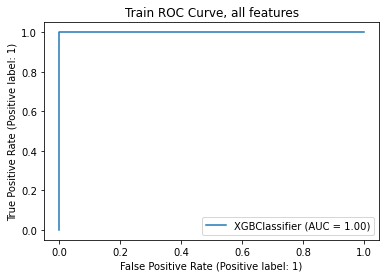

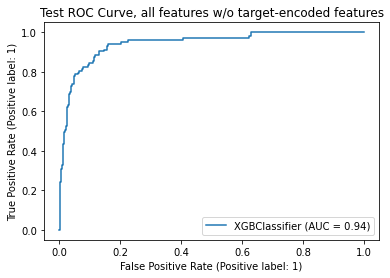

In [22]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(model, X_train2, y_train)
plt.title("Train ROC Curve, all features")
RocCurveDisplay.from_estimator(model, X_test2, y_test)
plt.title("Test ROC Curve, all features w/o target-encoded features")

Train PR-AUC is 1.00
min threshold:0.99 max threshold:1.00


Text(0.5, 1.0, 'Train Precision-Recall Curve, all w/o target-encoded features,PRAUC=1.0')

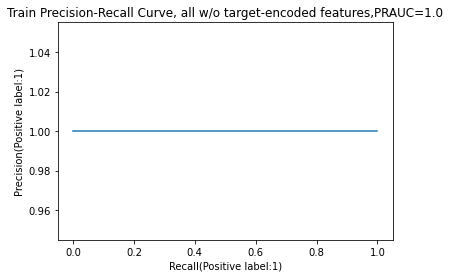

In [23]:
# plot train PR Curve 
from sklearn.metrics import precision_recall_curve
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html
from sklearn.metrics import auc,plot_precision_recall_curve
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html

train_precision1, train_recall1, train_thresholds1 = precision_recall_curve(y_train, y_train_pred_proba[:, 1])
train_auc_precision_recall1 = auc(train_recall1, train_precision1)
print('Train PR-AUC is {:.2f}'.format(train_auc_precision_recall1))

print('min threshold:{:.2f}'.format(min(train_thresholds1)), 'max threshold:{:.2f}'.format(max(train_thresholds1)))

plt.plot(train_recall1, train_precision1)
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Train Precision-Recall Curve, all w/o target-encoded features,PRAUC=1.0')

Test PR-AUC is 0.68
min threshold:0.00 max threshold:1.00


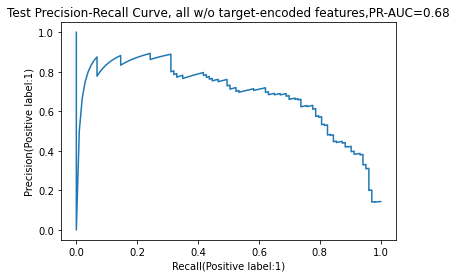

In [24]:
test_precision1, test_recall1, test_thresholds1 = precision_recall_curve(y_test, y_test_pred_proba[:, 1])
test_auc_precision_recall1 = auc(test_recall1, test_precision1)
print('Test PR-AUC is {:.2f}'.format(test_auc_precision_recall1))

print('min threshold:{:.2f}'.format(min(test_thresholds1)), 'max threshold:{:.2f}'.format(max(test_thresholds1)))

plt.plot(test_recall1, test_precision1)
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Test Precision-Recall Curve, all w/o target-encoded features,PR-AUC=0.68')
plt.show()

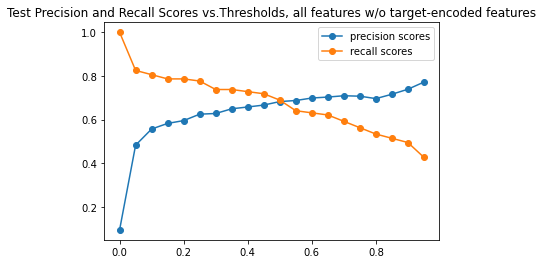

In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.arange(0,1,0.05,dtype = float)
prec_scores = []
recall_scores = []

for i in range(len(thresholds)):
    y_test_pred_new = (model.predict_proba(X_test2)[:,1]>thresholds[i]).astype(int)
    prec_scores.append(precision_score(y_test, y_test_pred_new))
    recall_scores.append(recall_score(y_test, y_test_pred_new))

plt.plot(thresholds, prec_scores, marker = 'o',label = 'precision scores')
plt.plot(thresholds, recall_scores,marker = 'o',label = 'recall scores')
plt.legend()
plt.title('Test Precision and Recall Scores vs.Thresholds, all features w/o target-encoded features')
plt.show()

## 2.Original DataSet, balanced,all features w/o target-encoded features, tuned

In [58]:
from sklearn.model_selection import GridSearchCV

#https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
#https://medium.com/data-design/xgboost-hi-im-gamma-what-can-i-do-for-you-and-the-tuning-of-regularization-a42ea17e6ab6

# param_grid = {
#                'max_depth':[5,7,10,15],
#                'min_child_weight':[1,3,5],
#                'gamma':[0,0.1,0.3,0.5],
#                'reg_lambda':[0.01, 0.1, 1, 10]}
# model2 = XGBClassifier(scale_pos_weight=scale_pos_weight,random_state=42)
# model2_gsv = GridSearchCV(model2, param_grid = param_grid,scoring = 'average_precision',cv=5)
# model2_gsv.fit(X_train2, y_train)
# model2_gsv.best_params_

{'gamma': 0, 'max_depth': 7, 'min_child_weight': 5, 'reg_lambda': 0.1}

In [26]:
model2 = XGBClassifier(gamma = 0, max_depth = 7, min_child_weight = 5,reg_lambda = 0.1,scale_pos_weight=scale_pos_weight,random_state=42)

In [27]:
train_scores2 = cross_val_score(model2, X_train2, y_train, scoring= 'average_precision', cv=5)
train_scores2.mean()

0.7483183037888262

In [28]:
model2.fit(X_train2,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=5,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=0.1, ...)

In [29]:
y_train_pred2 = model2.predict(X_train2)
y_train_pred_proba2 = model2.predict_proba(X_train2)

y_test_pred2 = model2.predict(X_test2)
y_test_pred_proba2 = model2.predict_proba(X_test2)

Text(0.5, 1.0, 'Test ROC Curve, all features w/o target-encoded features')

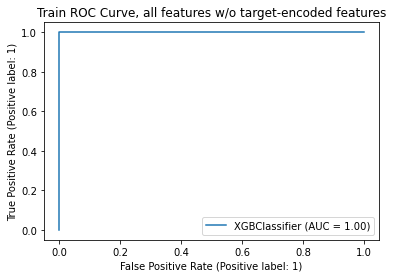

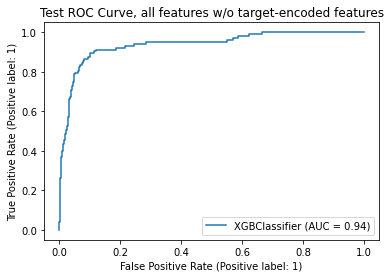

In [30]:
RocCurveDisplay.from_estimator(model2, X_train2, y_train)
plt.title("Train ROC Curve, all features w/o target-encoded features")
RocCurveDisplay.from_estimator(model2, X_test2, y_test)
plt.title("Test ROC Curve, all features w/o target-encoded features")

Train PR-AUC is 1.00
min threshold:0.98 max threshold:1.00


Text(0.5, 1.0, 'Train Precision-Recall Curve, all w/o target-encoded features,PRAUC=1.0')

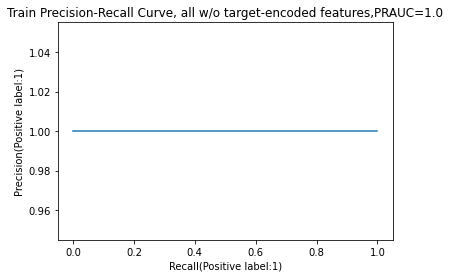

In [31]:
train_precision2, train_recall2, train_thresholds2 = precision_recall_curve(y_train, y_train_pred_proba2[:, 1])
train_auc_precision_recall2 = auc(train_recall2, train_precision2)
print('Train PR-AUC is {:.2f}'.format(train_auc_precision_recall2))

print('min threshold:{:.2f}'.format(min(train_thresholds2)), 'max threshold:{:.2f}'.format(max(train_thresholds2)))

plt.plot(train_recall2, train_precision2)
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Train Precision-Recall Curve, all w/o target-encoded features,PRAUC=1.0')

Test PR-AUC is 0.70
min threshold:0.00 max threshold:1.00


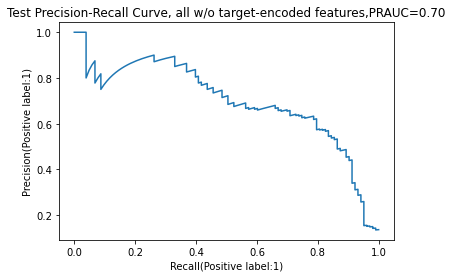

In [32]:
test_precision2, test_recall2, test_thresholds2 = precision_recall_curve(y_test, y_test_pred_proba2[:, 1])
test_auc_precision_recall2 = auc(test_recall2, test_precision2)
print('Test PR-AUC is {:.2f}'.format(test_auc_precision_recall2))

print('min threshold:{:.2f}'.format(min(test_thresholds2)), 'max threshold:{:.2f}'.format(max(test_thresholds2)))

plt.plot(test_recall2, test_precision2)
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Test Precision-Recall Curve, all w/o target-encoded features,PRAUC=0.70')
plt.show()

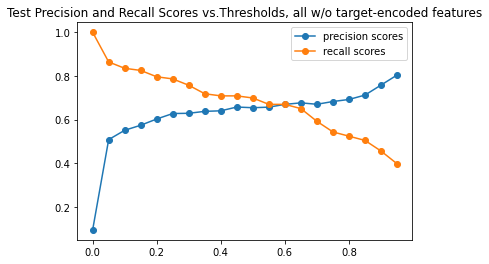

In [33]:
thresholds = np.arange(0,1,0.05,dtype = float)
prec_scores2 = []
recall_scores2 = []

for i in range(len(thresholds)):
    y_test_pred_new = (model2.predict_proba(X_test2)[:,1]>thresholds[i]).astype(int)
    prec_scores2.append(precision_score(y_test, y_test_pred_new))
    recall_scores2.append(recall_score(y_test, y_test_pred_new))

plt.plot(thresholds, prec_scores2, marker = 'o',label = 'precision scores')
plt.plot(thresholds, recall_scores2,marker = 'o',label = 'recall scores')
plt.legend()
plt.title('Test Precision and Recall Scores vs.Thresholds, all w/o target-encoded features')
plt.show()

In [34]:
# use CalibrateClassifierCV to calibrate probability
from sklearn.calibration import CalibratedClassifierCV

calibrated_clf = CalibratedClassifierCV(base_estimator=model2,cv='prefit',method = 'isotonic')
calibrated_clf.fit(X_test2, y_test)

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5,
                                                    booster='gbtree',
                                                    callbacks=None,
                                                    colsample_bylevel=1,
                                                    colsample_bynode=1,
                                                    colsample_bytree=1,
                                                    early_stopping_rounds=None,
                                                    enable_categorical=False,
                                                    eval_metric=None, gamma=0,
                                                    gpu_id=-1,
                                                    grow_policy='depthwise',
                                                    importance_type=None,
                                                    interaction_constraints='',
                                                    learning_rate=0.300000012,
                                                    max_bin=256,
                                                    max_cat_to_onehot=4,
                                                    max_delta_step=0,
                                                    max_depth=7, max_leaves=0,
                                                    min_child_weight=5,
                                                    missing=nan,
                                                    monotone_constraints='()',
                                                    n_estimators=100, n_jobs=0,
                                                    num_parallel_tree=1,
                                                    predictor='auto',
                                                    random_state=42,
                                                    reg_alpha=0, reg_lambda=0.1, ...),
                       cv='prefit', method='isotonic')

In [35]:
y_test_proba_isotonic = calibrated_clf.predict_proba(X_test2)

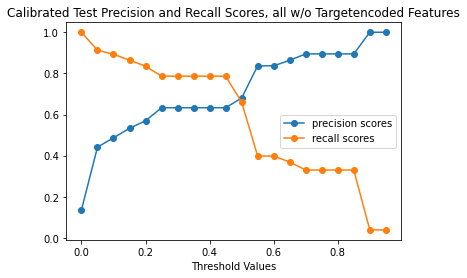

In [36]:
thresholds = np.arange(0,1,0.05,dtype = float)
prec_scores2_isotonic = []
recall_scores2_isotonic = []

for i in range(len(thresholds)):
    y_test_pred_new = (calibrated_clf.predict_proba(X_test2)[:,1]>thresholds[i]).astype(int)
    prec_scores2_isotonic.append(precision_score(y_test, y_test_pred_new))
    recall_scores2_isotonic.append(recall_score(y_test, y_test_pred_new))

plt.plot(thresholds, prec_scores2_isotonic, marker = 'o',label = 'precision scores')
plt.plot(thresholds, recall_scores2_isotonic,marker = 'o',label = 'recall scores')
plt.legend()
plt.title('Calibrated Test Precision and Recall Scores, all w/o Targetencoded Features')
plt.xlabel('Threshold Values')
plt.show()

In [40]:
importances = model2.feature_importances_
features = model2.feature_names_in_
xgb_importances = pd.Series(importances, index = features)
xgb_importances.sort_values(ascending = False)

TotalInscClaimAmtReimbursed     0.318802
MaxHospitalDays                 0.047821
OPAnnualReimbursementAmt_sum    0.027102
ClmsperBene                     0.017733
totalDiagCode_41401             0.017437
                                  ...   
totalProcCode_8154              0.000000
totalProcCode_2724              0.000000
totalProcCode_9904              0.000000
totalProcCode_4019              0.000000
totalProcCode_Other             0.000000
Length: 102, dtype: float32

In [41]:
top50features = xgb_importances.sort_values(ascending = False)[:50].index

In [42]:
xgb_importances.loc[top50features]

TotalInscClaimAmtReimbursed           0.318802
MaxHospitalDays                       0.047821
OPAnnualReimbursementAmt_sum          0.027102
ClmsperBene                           0.017733
totalDiagCode_41401                   0.017437
InClmsPct                             0.015517
RenalDiseaseIndicator                 0.014400
OPAnnualReimbursementAmt_max          0.014211
totalDiagCode_42731                   0.014096
totalDiagCode_496                     0.013935
totalDiagCode_2449                    0.013734
MaxProcCodeNumPerClaim                0.013578
OPAnnualDeductibleAmt_sum             0.013342
TotalHighFreqProcCodeNumPerClaim      0.012690
ClaimPeriod                           0.011824
uniqOTPhysnCount                      0.011590
DeductibleAmtPaid_mean                0.010437
Chronic_Heartfailure_Frac             0.009823
ClaimCounts                           0.009772
MeanInscClaimAmtReimbursed            0.009688
MeanDiagCodeNumPerClaim               0.009612
MajorCounty  

Text(0.5, 0, 'coefficient')

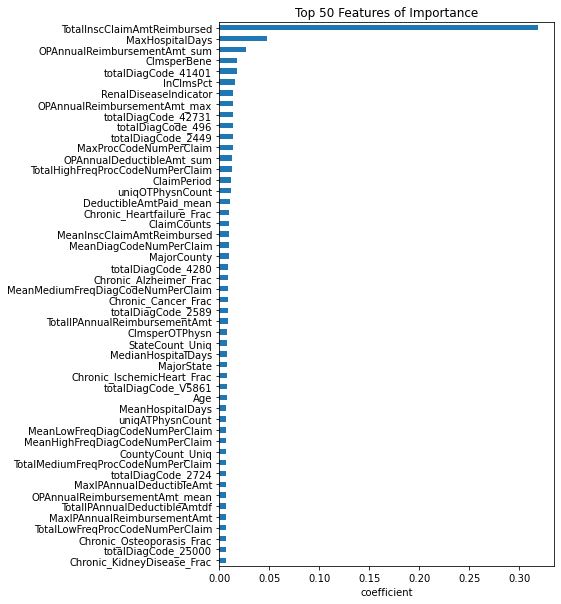

In [43]:
fig = plt.figure(figsize = (6,10))
xgb_importances.loc[top50features].sort_values(ascending = True).plot.barh(title = 'Top 50 Features of Importance')
plt.xlabel('coefficient')

In [44]:
top15features = xgb_importances.sort_values(ascending = False)[:15].index

In [55]:
X_train2_top15 = X_train2[top15features]
X_test2_top15 = X_test2[top15features]

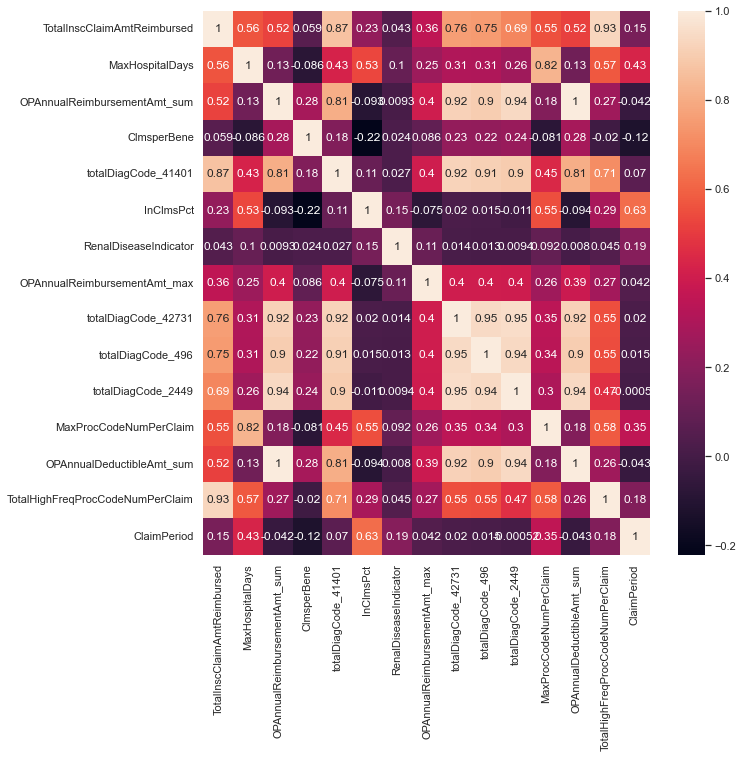

In [56]:
import seaborn as sns
sns.set(rc={'figure.figsize':(10,10)})
dataplot=sns.heatmap(X_train2_top15.corr(method = 'pearson'), annot=True)
plt.show()

In [57]:
top15features

Index(['TotalInscClaimAmtReimbursed', 'MaxHospitalDays',
       'OPAnnualReimbursementAmt_sum', 'ClmsperBene', 'totalDiagCode_41401',
       'InClmsPct', 'RenalDiseaseIndicator', 'OPAnnualReimbursementAmt_max',
       'totalDiagCode_42731', 'totalDiagCode_496', 'totalDiagCode_2449',
       'MaxProcCodeNumPerClaim', 'OPAnnualDeductibleAmt_sum',
       'TotalHighFreqProcCodeNumPerClaim', 'ClaimPeriod'],
      dtype='object')

TotalInscClaimAmtReimbursed - TotalHighFreqProcCodeNumPerClaim
<br>OPAnnualReimbursementAmt_sum- totalDiagCode_42731', 'totalDiagCode_496', 'totalDiagCode_2449
<br>totalDiagCode_42731' - OPAnnualReimbursementAmt_sum- totalDiagCode_41401-'totalDiagCode_496', 'totalDiagCode_2449 - OPAnnualDeductibleAmt_sum

In [58]:
to_be_removed = ['TotalHighFreqProcCodeNumPerClaim','totalDiagCode_42731','totalDiagCode_496','totalDiagCode_2449']

In [59]:
top11features = []
for item in top15features:
    if item not in to_be_removed:
        top11features.append(item)
top11features

['TotalInscClaimAmtReimbursed',
 'MaxHospitalDays',
 'OPAnnualReimbursementAmt_sum',
 'ClmsperBene',
 'totalDiagCode_41401',
 'InClmsPct',
 'RenalDiseaseIndicator',
 'OPAnnualReimbursementAmt_max',
 'MaxProcCodeNumPerClaim',
 'OPAnnualDeductibleAmt_sum',
 'ClaimPeriod']

In [60]:
X_train2_top11 = X_train2[top11features]
X_test2_top11 = X_test2[top11features]

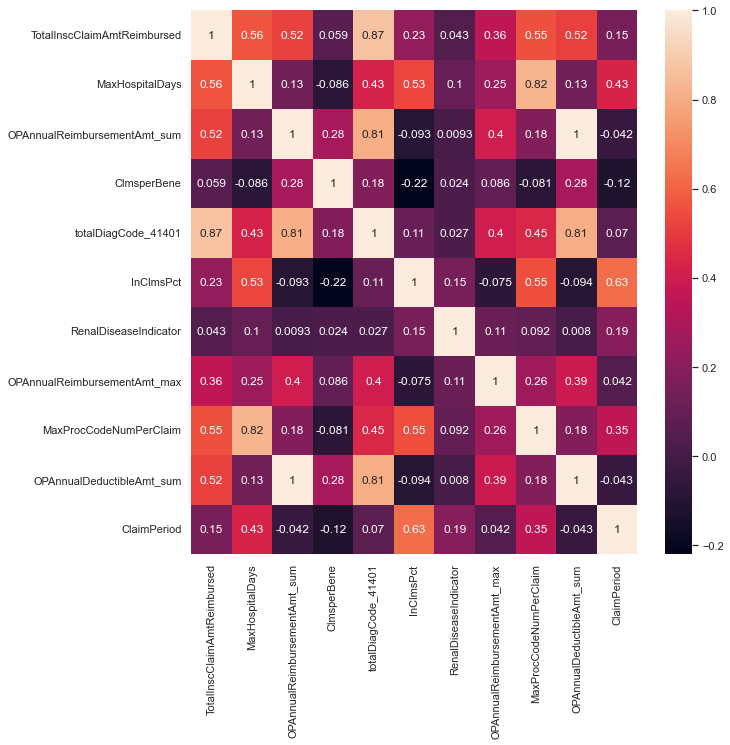

In [61]:
dataplot=sns.heatmap(X_train2_top11.corr(method = 'pearson'), annot=True)

In [94]:
from sklearn.model_selection import GridSearchCV
param_grid = {
                'max_depth':[10,15,20],
                'min_child_weight':[1,3,5,8],
                'gamma':[0,0.5,1.0,5],
                'reg_lambda':[0.1,1,5,10,50]}
model3 = XGBClassifier(scale_pos_weight=scale_pos_weight,random_state=42)

model3_gsv = GridSearchCV(model3, param_grid = param_grid,scoring = 'average_precision',cv=5)
model3_gsv.fit(X_train2_top11, y_train)
model3_gsv.best_params_

{'gamma': 0, 'max_depth': 10, 'min_child_weight': 1, 'reg_lambda': 50}

In [95]:
model3 = XGBClassifier(gamma = 0, max_depth = 10, min_child_weight = 1,reg_lambda = 50,scale_pos_weight=scale_pos_weight,random_state=42)

In [96]:
train_scores3 = cross_val_score(model3, X_train2_top11, y_train, scoring= 'average_precision', cv=5)
train_scores3.mean()

0.7330842178501951

In [97]:
model3.fit(X_train2_top11,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=50, ...)

In [98]:
y_train_pred3 = model3.predict(X_train2_top11)
y_train_pred_proba3 = model3.predict_proba(X_train2_top11)

y_test_pred3 = model3.predict(X_test2_top11)
y_test_pred_proba3 = model3.predict_proba(X_test2_top11)

Text(0.5, 1.0, 'Test ROC Curve, Select Top 11 features w/o target-encoded features')

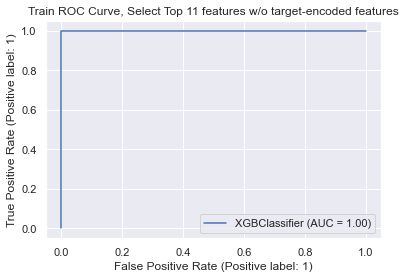

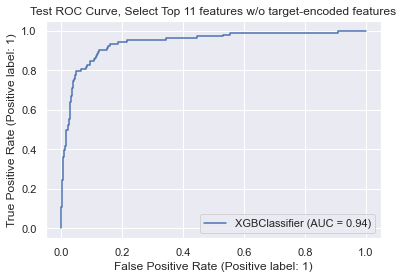

In [99]:
sns.set(rc={'figure.figsize':(6,4)})
RocCurveDisplay.from_estimator(model3, X_train2_top11, y_train)
plt.title("Train ROC Curve, Select Top 11 features w/o target-encoded features")
RocCurveDisplay.from_estimator(model3, X_test2_top11, y_test)
plt.title("Test ROC Curve, Select Top 11 features w/o target-encoded features")

Train PR-AUC is 1.00
min threshold:0.81 max threshold:1.00


Text(0.5, 1.0, 'Train Precision-Recall Curve, Select Top 11 w/o target-encoded features,PRAUC=1.0')

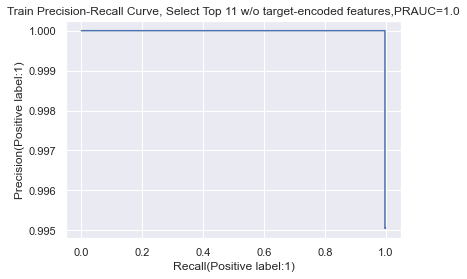

In [100]:
train_precision3, train_recall3, train_thresholds3 = precision_recall_curve(y_train, y_train_pred_proba3[:, 1])
train_auc_precision_recall3 = auc(train_recall3, train_precision3)
print('Train PR-AUC is {:.2f}'.format(train_auc_precision_recall3))

print('min threshold:{:.2f}'.format(min(train_thresholds3)), 'max threshold:{:.2f}'.format(max(train_thresholds3)))

plt.plot(train_recall3, train_precision3)
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Train Precision-Recall Curve, Select Top 11 w/o target-encoded features,PRAUC=1.0')

Test PR-AUC is 0.72
min threshold:0.00 max threshold:1.00


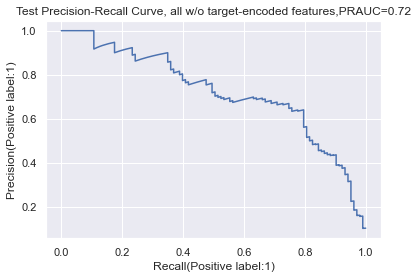

In [101]:
test_precision3, test_recall3, test_thresholds3 = precision_recall_curve(y_test, y_test_pred_proba3[:, 1])
test_auc_precision_recall3 = auc(test_recall3, test_precision3)
print('Test PR-AUC is {:.2f}'.format(test_auc_precision_recall3))

print('min threshold:{:.2f}'.format(min(test_thresholds3)), 'max threshold:{:.2f}'.format(max(test_thresholds3)))

plt.plot(test_recall3, test_precision3)
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Test Precision-Recall Curve, all w/o target-encoded features,PRAUC=0.72')
plt.show()

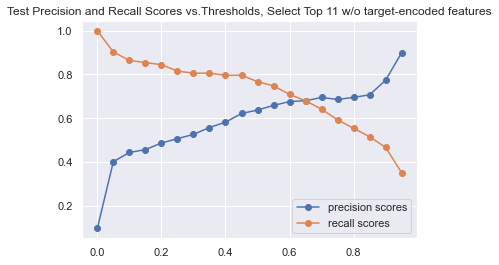

In [102]:
thresholds = np.arange(0,1,0.05,dtype = float)
prec_scores3 = []
recall_scores3 = []

for i in range(len(thresholds)):
    y_test_pred_new = (model3.predict_proba(X_test2_top11)[:,1]>thresholds[i]).astype(int)
    prec_scores3.append(precision_score(y_test, y_test_pred_new))
    recall_scores3.append(recall_score(y_test, y_test_pred_new))

plt.plot(thresholds, prec_scores3, marker = 'o',label = 'precision scores')
plt.plot(thresholds, recall_scores3,marker = 'o',label = 'recall scores')
plt.legend()
plt.title('Test Precision and Recall Scores vs.Thresholds, Select Top 11 w/o target-encoded features')
plt.show()

In [103]:
calibrated_clf3 = CalibratedClassifierCV(base_estimator=model3,cv='prefit',method = 'isotonic')
calibrated_clf3.fit(X_test2_top11, y_test)

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5,
                                                    booster='gbtree',
                                                    callbacks=None,
                                                    colsample_bylevel=1,
                                                    colsample_bynode=1,
                                                    colsample_bytree=1,
                                                    early_stopping_rounds=None,
                                                    enable_categorical=False,
                                                    eval_metric=None, gamma=0,
                                                    gpu_id=-1,
                                                    grow_policy='depthwise',
                                                    importance_type=None,
                                                    interaction_constraints='',
                                                    learning_rate=0.300000012,
                                                    max_bin=256,
                                                    max_cat_to_onehot=4,
                                                    max_delta_step=0,
                                                    max_depth=10, max_leaves=0,
                                                    min_child_weight=1,
                                                    missing=nan,
                                                    monotone_constraints='()',
                                                    n_estimators=100, n_jobs=0,
                                                    num_parallel_tree=1,
                                                    predictor='auto',
                                                    random_state=42,
                                                    reg_alpha=0, reg_lambda=50, ...),
                       cv='prefit', method='isotonic')

In [104]:
y_test_proba_isotonic3 = calibrated_clf3.predict_proba(X_test2_top11)

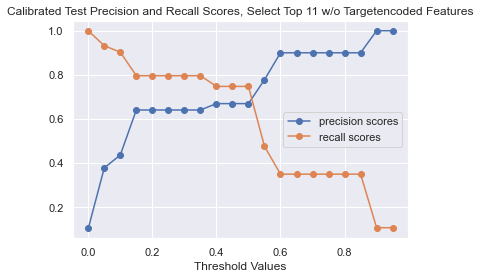

In [105]:
thresholds = np.arange(0,1,0.05,dtype = float)
prec_scores3_isotonic = []
recall_scores3_isotonic = []

for i in range(len(thresholds)):
    y_test_pred_new = (calibrated_clf3.predict_proba(X_test2_top11)[:,1]>thresholds[i]).astype(int)
    prec_scores3_isotonic.append(precision_score(y_test, y_test_pred_new))
    recall_scores3_isotonic.append(recall_score(y_test, y_test_pred_new))

plt.plot(thresholds, prec_scores3_isotonic, marker = 'o',label = 'precision scores')
plt.plot(thresholds, recall_scores3_isotonic,marker = 'o',label = 'recall scores')
plt.legend()
plt.title('Calibrated Test Precision and Recall Scores, Select Top 11 w/o Targetencoded Features')
plt.xlabel('Threshold Values')
plt.show()

In [106]:
prec_scores3_isotonic

[0.1035175879396985,
 0.3779527559055118,
 0.43661971830985913,
 0.640625,
 0.640625,
 0.640625,
 0.640625,
 0.640625,
 0.6695652173913044,
 0.6695652173913044,
 0.6695652173913044,
 0.7777777777777778,
 0.9,
 0.9,
 0.9,
 0.9,
 0.9,
 0.9,
 1.0,
 1.0]

In [107]:
recall_scores3_isotonic

[1.0,
 0.9320388349514563,
 0.9029126213592233,
 0.7961165048543689,
 0.7961165048543689,
 0.7961165048543689,
 0.7961165048543689,
 0.7961165048543689,
 0.7475728155339806,
 0.7475728155339806,
 0.7475728155339806,
 0.47572815533980584,
 0.34951456310679613,
 0.34951456310679613,
 0.34951456310679613,
 0.34951456310679613,
 0.34951456310679613,
 0.34951456310679613,
 0.10679611650485436,
 0.10679611650485436]